In [22]:
%pip install newsapi-python
%pip install --upgrade transformers
%pip install bert-for-sequence-classification
from newsapi import NewsApiClient
import json
import torch
from wordcloud import WordCloud
import pandas as pd
import os
print(torch.__version__)

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: C:\Users\franc\OneDrive\Documents\Admin\Universiteit\Akademies\Year 3\Data Science 346\Project\DS346proj\myenv\Scripts\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: C:\Users\franc\OneDrive\Documents\Admin\Universiteit\Akademies\Year 3\Data Science 346\Project\DS346proj\myenv\Scripts\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
2.4.1+cpu



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: C:\Users\franc\OneDrive\Documents\Admin\Universiteit\Akademies\Year 3\Data Science 346\Project\DS346proj\myenv\Scripts\python.exe -m pip install --upgrade pip


In [23]:
import os
import json
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Ensure necessary NLTK resources are downloaded
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
sid = SentimentIntensityAnalyzer()



# Function to load articles from local files
def get_articles():
    # Load Harris articles from local file
    with open('dataset/cleaned_harris_articles.json', 'r') as harris_file:
        harris_articles = json.load(harris_file)

    # Load Trump articles from local file
    with open('dataset/cleaned_trump_articles.json', 'r') as trump_file:
        trump_articles = json.load(trump_file)
    
    # Assuming the structure is already a list of articles in both JSON files
    return harris_articles, trump_articles

# Call the function to get articles
harris_articles, trump_articles = get_articles()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [33]:
import re
from nltk.tokenize import sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    
    patterns = [r'\bkamala\b', r'\bharris\b', r'\bdonald\b', r'\btrump\b', r'\btrumps\b']
    for pattern in patterns:
        text = re.sub(pattern, '', text)
    
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word.isalpha()]
    
    words = [word for word in words if word not in stop_words]
    
    return ' '.join(words)

def calculate_sentiment_for_article(article):
    """
    Calculate the total sentiment score for an article.
    """
    sentences = sent_tokenize(article)
    total_score = 0
    
    # Calculate sentiment for each sentence and sum the scores
    for sentence in sentences:
        
        sentiment = sid.polarity_scores(sentence)
        total_score += sentiment['compound']
    
    return total_score

def process_articles(articles, publication_dates, candidate_name):
    candidate_data = []
    
    for article, published_at in zip(articles, publication_dates):
        cleaned_article = preprocess(article)
        score = calculate_sentiment_for_article(cleaned_article)
        
        candidate_data.append({
            'article': cleaned_article,
            'candidate': candidate_name,
            'score': score,
            'publishedAt': published_at  # Include the published date
        })
    
    return candidate_data

clean_harris_articles = [article.get('title', '') or article.get('description', '') for article in harris_articles]
harris_publication_dates = [article['publishedAt'] for article in harris_articles]

clean_trump_articles = [article.get('title', '') or article.get('description', '') for article in trump_articles]
trump_publication_dates = [article['publishedAt'] for article in trump_articles]

print(f"Harris Articles: {len(clean_harris_articles)}")
print(f"Trump Articles: {len(clean_trump_articles)}")

harris_data = process_articles(clean_harris_articles, harris_publication_dates, "Kamala Harris")
trump_data = process_articles(clean_trump_articles, trump_publication_dates, "Donald Trump")

articles_data = harris_data + trump_data

df_articles = pd.DataFrame(articles_data)

print(df_articles)


Harris Articles: 407
Trump Articles: 361
                                               article      candidate   score  \
0                     accepts cnn invitation tv debate  Kamala Harris  0.3182   
1    dont need call dumb nikki haley shared exactly...  Kamala Harris  0.6251   
2                         say wont run beaten november  Kamala Harris  0.3252   
3    hawk silver coin silveradding bible sneaker me...  Kamala Harris  0.0000   
4       trash zelensky greatest salesman earth visit u  Kamala Harris  0.6369   
..                                                 ...            ...     ...   
763  election update campaign address plagiarism cl...   Donald Trump  0.0000   
764  esper take comment using military american ser...   Donald Trump -0.1779   
765  jimmy kimmel refutes claim appeared show lot r...   Donald Trump  0.0000   
766  economic plan would worsen inflation expert sa...   Donald Trump -0.5106   
767  fact check make least false claim onehour fox ...   Donald Trum

In [34]:
#Topic Modelling

from gensim import corpora
from gensim.models.ldamodel import LdaModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation


def perform_topic_modeling(articles, num_topics=5):

    vectorizer = TfidfVectorizer()
    doc_term_matrix = vectorizer.fit_transform(articles)
    
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=0)
    lda.fit(doc_term_matrix)
    
    # Get the topics
    topics = []
    for idx, topic in enumerate(lda.components_):
        topics.append([(vectorizer.get_feature_names_out()[i], topic[i]) for i in topic.argsort()[-10:]])

    return topics


combined_articles = df_articles['article'].tolist()
topics = perform_topic_modeling(combined_articles)

harris_topics = perform_topic_modeling([row['article'] for row in harris_data], num_topics=5)

trump_topics = perform_topic_modeling([row['article'] for row in trump_data], num_topics=5)

harris_topic_data = []

for i, topic in enumerate(harris_topics):
    keywords = [word for word, _ in topic]
    harris_topic_data.append({'Topic': f'Topic {i + 1}', 'Keywords': ', '.join(keywords)})

harris_topic_df = pd.DataFrame(harris_topic_data)

trump_topic_data = []

for i, topic in enumerate(trump_topics):
    keywords = [word for word, _ in topic]
    trump_topic_data.append({'Topic': f'Topic {i + 1}', 'Keywords': ', '.join(keywords)})

trump_topic_df = pd.DataFrame(trump_topic_data)

print("\nTop Topics for Kamala Harris:")
print(harris_topic_df)

print("\nTop Topics for Donald Trump:")
print(trump_topic_df)


Top Topics for Kamala Harris:
     Topic                                           Keywords
0  Topic 1  ha, wa, biden, cnn, debate, news, vote, say, e...
1  Topic 2  agrees, liz, interview, men, new, slam, rally,...
2  Topic 3  debate, voter, world, watch, interview, poll, ...
3  Topic 4  economy, week, president, election, news, liz,...
4  Topic 5  black, minute, republican, voter, want, say, n...

Top Topics for Donald Trump:
     Topic                                           Keywords
0  Topic 1  assassination, vote, biden, bidenharris, voter...
1  Topic 2  get, head, win, question, news, voter, momentu...
2  Topic 3  cant, blame, state, war, new, bidenharris, bre...
3  Topic 4  call, post, endorsement, lawrence, debate, new...
4  Topic 5  encounter, woman, president, campaign, bus, dr...


In [26]:

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
from nltk.corpus import wordnet as wn
import pandas as pd
from nltk.tokenize import word_tokenize

# Load the NRC Emotion Lexicon
nrc = pd.read_csv('NRC-Emotion-Lexicon-Wordlevel-v0.92.txt', sep='\t', names=["word", "emotion", "association"])
nrc = nrc.pivot(index='word', columns='emotion', values='association').reset_index()

def get_emotions(text):
    """
    Get the emotion scores for a given text based on the NRC lexicon.
    """
    words = word_tokenize(text.lower())
    emotions = {emotion: 0 for emotion in nrc.columns[1:]}
    
    for word in words:
        if word in nrc['word'].values:
            word_emotions = nrc[nrc['word'] == word].iloc[0, 1:]
            for emotion in word_emotions.index:
                emotions[emotion] += word_emotions[emotion]
    
    return emotions

def process_articles_for_emotions(articles, publication_dates, candidate_name):
    """
    Process a list of articles and calculate the emotion scores for each article.
    """
    articles_emotions = []
    
    for article, published_at in zip(articles, publication_dates):
        emotions = get_emotions(article)
        articles_emotions.append({
            'article': article,
            'candidate': candidate_name,
            'publishedAt': published_at,  # Include the published date
            **emotions  # Unpack the emotion scores into the dictionary
        })
    
    return articles_emotions

harris_emotions = process_articles_for_emotions(clean_harris_articles, harris_publication_dates, "Kamala Harris")
trump_emotions = process_articles_for_emotions(clean_trump_articles, trump_publication_dates, "Donald Trump")

combined_emotions = harris_emotions + trump_emotions

df_emotions = pd.DataFrame(combined_emotions)

print(df_emotions)


                                               article      candidate  \
0    kamala harris accepts cnn invitation for tv de...  Kamala Harris   
1    you dont need to call kamala dumb nikki haley ...  Kamala Harris   
2    that will be it trump says wont run again if b...  Kamala Harris   
3    trump hawks a  silver coin with about  in silv...  Kamala Harris   
4    trump trashes zelensky as greatest salesman on...  Kamala Harris   
..                                                 ...            ...   
763  election updates harris campaign addresses pla...   Donald Trump   
764  esper take trump comments about using military...   Donald Trump   
765  jimmy kimmel refutes donald trumps claim he ap...   Donald Trump   
766  trumps economic plans would worsen inflation e...   Donald Trump   
767  fact check trump makes at least  false claims ...   Donald Trump   

              publishedAt  anger  anticipation  disgust  fear  joy  negative  \
0    2024-09-21T17:53:38Z      0           

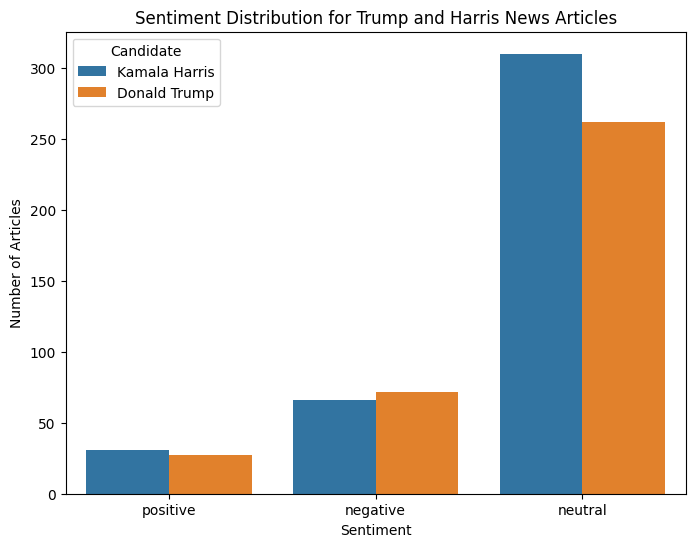

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize Sentiment Intensity Analyzer
sid = SentimentIntensityAnalyzer()

def calculate_sentiment_distribution(articles):
    """
    Calculate the number of positive, negative, and neutral articles based on compound sentiment scores.
    """
    sentiments = {'positive': 0, 'negative': 0, 'neutral': 0}

    for article in articles:
        compound_score = sid.polarity_scores(article)['compound']
        
        if compound_score > 0.5:
            sentiments['positive'] += 1
        elif compound_score < -0.5:
            sentiments['negative'] += 1
        else:
            sentiments['neutral'] += 1
    
    return sentiments

harris_sentiment_distribution = calculate_sentiment_distribution(clean_harris_articles)
trump_sentiment_distribution = calculate_sentiment_distribution(clean_trump_articles)

sentiment_labels = ['positive', 'negative', 'neutral']
harris_counts = [harris_sentiment_distribution[sentiment] for sentiment in sentiment_labels]
trump_counts = [trump_sentiment_distribution[sentiment] for sentiment in sentiment_labels]

df_sentiment = pd.DataFrame({
    'Sentiment': sentiment_labels * 2,
    'Count': harris_counts + trump_counts,
    'Candidate': ['Kamala Harris'] * 3 + ['Donald Trump'] * 3
})

plt.figure(figsize=(8, 6))
sns.barplot(x='Sentiment', y='Count', hue='Candidate', data=df_sentiment)
plt.title('Sentiment Distribution for Trump and Harris News Articles')
plt.ylabel('Number of Articles')
plt.show()



                                             article     candidate  \
0  talking nevada voter role state could play ele...  Donald Trump   
1  uncommitted movement doesnt endorse asks suppo...  Donald Trump   
2                vance turning dude influencers edge  Donald Trump   
3  campaign jewish group blast blaming jewish vot...  Donald Trump   
4  biggest celebrity endorsement fran drescher bi...  Donald Trump   

   trump_score           publishedAt  combined_score  kamala_score  
0       0.3400  2024-09-23T09:00:00Z          0.3400           NaN  
1      -0.4168  2024-09-19T17:34:49Z         -0.4168           NaN  
2       0.0000  2024-09-24T13:37:13Z          0.0000           NaN  
3      -0.6705  2024-09-20T20:41:23Z         -0.6705           NaN  
4       0.3182  2024-09-23T16:11:24Z          0.3182           NaN  
       trump_score  combined_score  kamala_score
count   361.000000      768.000000    407.000000
mean     -0.093324       -0.025418     -0.034812
std       0.404477

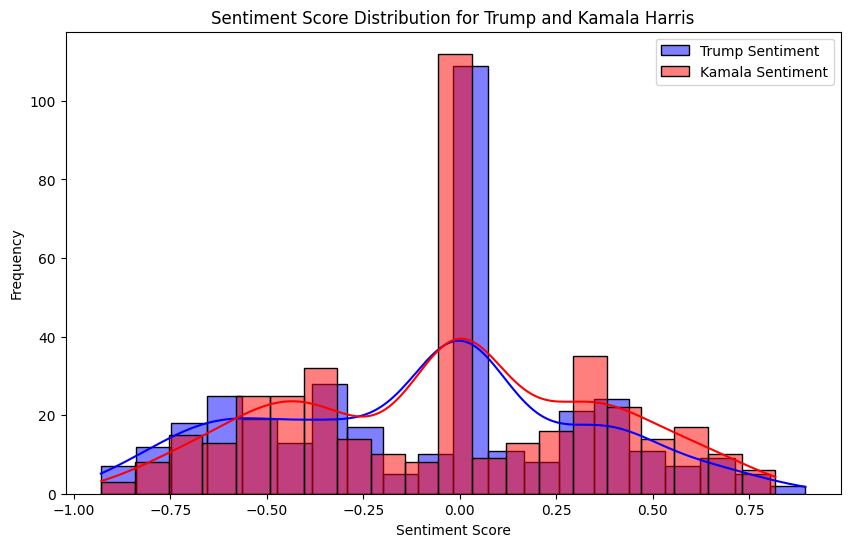

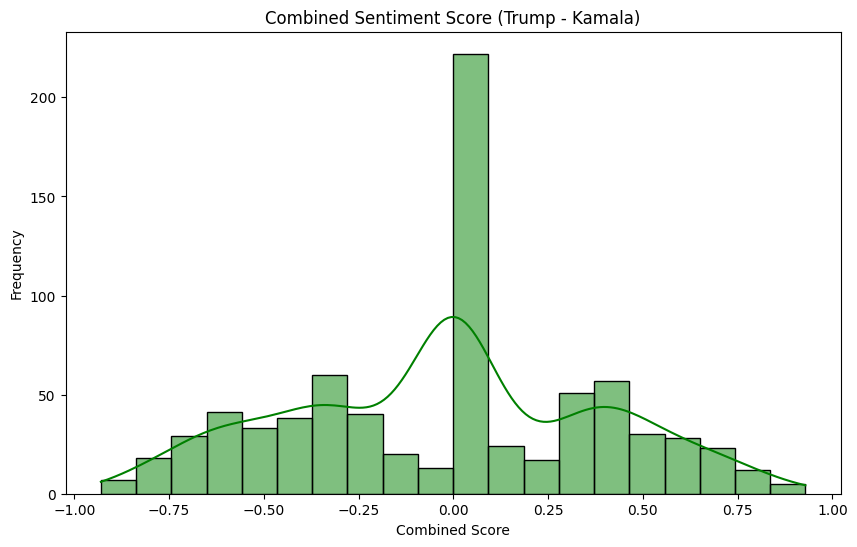

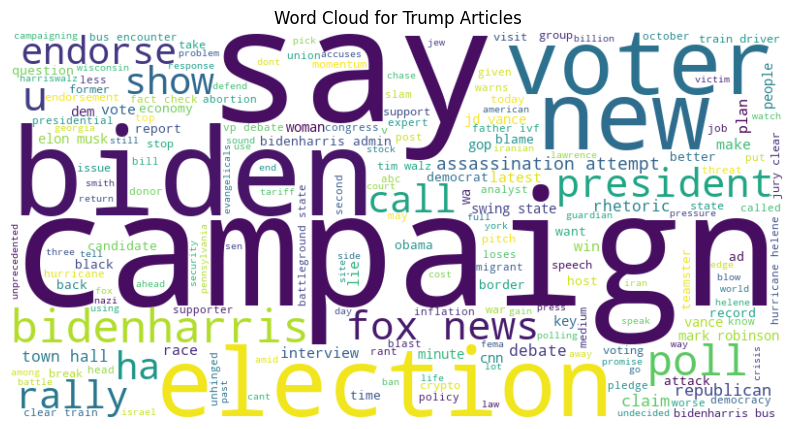

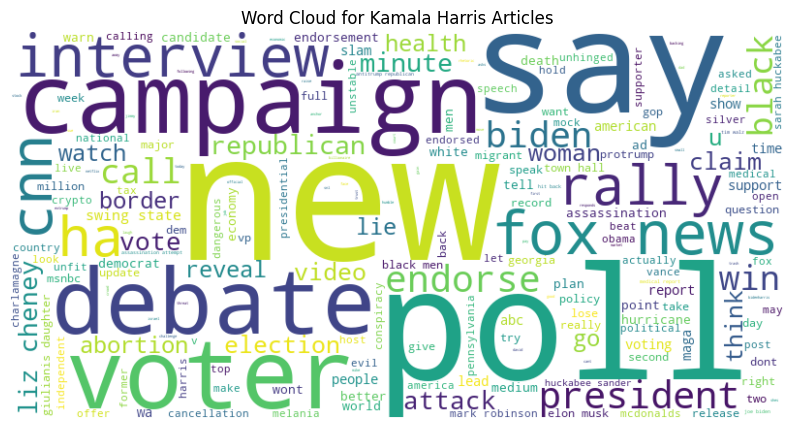

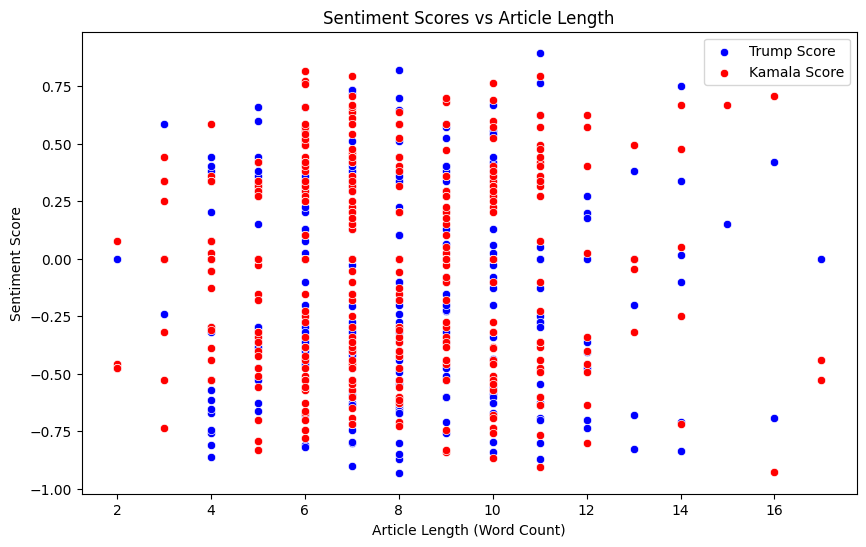

C:\Users\franc\AppData\Local\Temp\ipykernel_1956\2873048386.py:78: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df.groupby(df['date'].dt.to_period("W"))['combined_score'].mean().plot()


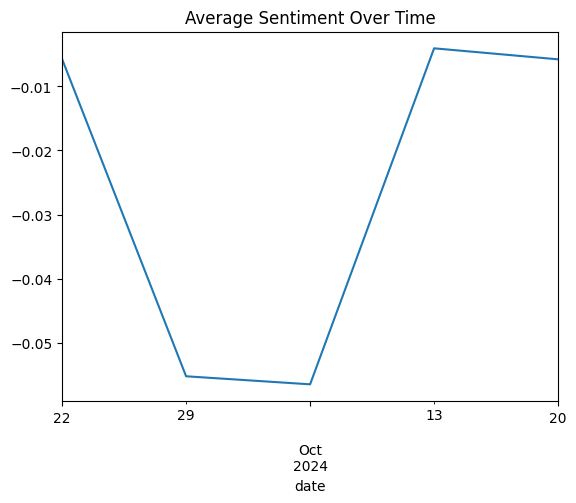

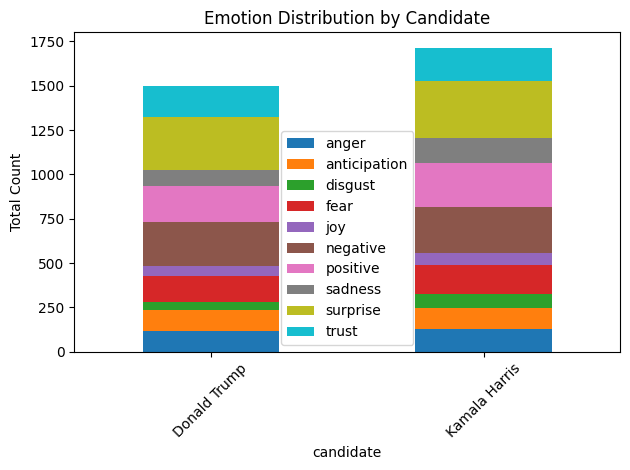

Most positive article for Trump: outstanding enthusiastic praise mark robinson recirculates candidate black nazi brag revealed
Most negative article for Trump: slam pelosis sick evil doubling enemy within rhetoric
Most positive article for Kamala: ha reached ceiling ability make gain
Most negative article for Kamala: rage fake news reporter mcdonalds story rally rant vow next week hell try french fry job


In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

df_trump = pd.DataFrame(trump_data)
df_harris = pd.DataFrame(harris_data)

df_trump = df_trump.rename(columns={'score': 'trump_score'})
df_harris = df_harris.rename(columns={'score': 'kamala_score'})

# Add a 'combined_score' column to reflect sentiment difference (Trump - Kamala)
df_trump['combined_score'] = df_trump['trump_score']
df_harris['combined_score'] = -df_harris['kamala_score']


df = pd.concat([df_trump, df_harris], ignore_index=True)

print(df.head())


print(df.describe())

print(f"Total number of articles: {len(df)}")

# Count articles favoring Trump (combined_score > 0) vs Kamala (combined_score < 0)
trump_favored = (df['combined_score'] > 0).sum()
kamala_favored = (df['combined_score'] < 0).sum()
print(f"Articles favoring Trump: {trump_favored}")
print(f"Articles favoring Kamala: {kamala_favored}")

# Distribution of Trump and Kamala sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(df_trump['trump_score'], color='blue', label='Trump Sentiment', kde=True, bins=20)
sns.histplot(df_harris['kamala_score'], color='red', label='Kamala Sentiment', kde=True, bins=20)
plt.title('Sentiment Score Distribution for Trump and Kamala Harris')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Combined sentiment score (Trump - Kamala)
plt.figure(figsize=(10, 6))
sns.histplot(df['combined_score'], color='green', kde=True, bins=20)
plt.title('Combined Sentiment Score (Trump - Kamala)')
plt.xlabel('Combined Score')
plt.ylabel('Frequency')
plt.show()

# Function to create word cloud
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

trump_articles_text = " ".join(df_trump['article'])
kamala_articles_text = " ".join(df_harris['article'])

plot_wordcloud(trump_articles_text, "Word Cloud for Trump Articles")
plot_wordcloud(kamala_articles_text, "Word Cloud for Kamala Harris Articles")

df_trump['article_length'] = df_trump['article'].apply(lambda x: len(x.split()))
df_harris['article_length'] = df_harris['article'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.scatterplot(x='article_length', y='trump_score', data=df_trump, label='Trump Score', color='blue')
sns.scatterplot(x='article_length', y='kamala_score', data=df_harris, label='Kamala Score', color='red')
plt.title('Sentiment Scores vs Article Length')
plt.xlabel('Article Length (Word Count)')
plt.ylabel('Sentiment Score')
plt.legend()
plt.show()

df['date'] = pd.to_datetime(df['publishedAt'])  # Ensure you have a date column
df.groupby(df['date'].dt.to_period("W"))['combined_score'].mean().plot()
plt.title('Average Sentiment Over Time')
plt.show()

emotion_counts = df_emotions.groupby('candidate')[['anger', 'anticipation', 'disgust', 'fear', 
                                                    'joy', 'negative', 'positive', 'sadness', 
                                                    'surprise', 'trust']].sum()

emotion_counts.plot(kind='bar', stacked=True)
plt.title('Emotion Distribution by Candidate')
plt.ylabel('Total Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Find the most positive/negative articles for Trump and Kamala
most_positive_trump = df_trump.loc[df_trump['trump_score'].idxmax()]['article']
most_negative_trump = df_trump.loc[df_trump['trump_score'].idxmin()]['article']
most_positive_kamala = df_harris.loc[df_harris['kamala_score'].idxmax()]['article']
most_negative_kamala = df_harris.loc[df_harris['kamala_score'].idxmin()]['article']

print(f"Most positive article for Trump: {most_positive_trump}")
print(f"Most negative article for Trump: {most_negative_trump}")
print(f"Most positive article for Kamala: {most_positive_kamala}")
print(f"Most negative article for Kamala: {most_negative_kamala}")
